In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import csv
import json
import sklearn
from google.cloud import bigquery as bq
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pathlib

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.options.mode.chained_assignment = None
%matplotlib inline

In [2]:
# # explore gradient boosting number of trees effect on performance
# from numpy import mean
# from numpy import std
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
 

In [3]:
# Set random seeds

sampling_seed = np.random.seed(13)
train_test_seed = np.random.seed(69)
cv_seed = np.random.seed(37)
model_seed = np.random.seed(73)
np.random.seed(42) # set default seed value

In [ ]:
label_col = ["bldg_height"]
# num_cols = ["area", "perimeter", "length", "building_levels", "year", "count_vertices", "compactness", "complexity", "count_neighbor"]
num_cols = ["area", "perimeter", "length", "building_levels", "year", "count_vertices", "compactness", "complexity", "count_neighbor"]
cat_cols = ["city", "postcode", "country", "state_name"]
# cat_cols = [col for col in df.columns if col not in (num_cols + label_col)]

In [ ]:
def get_df(bq_table_name, sample_frac=None):
    query="""
    SELECT
      *
    FROM
      `ual3d-277909.nl.%s`
    """ % (bq_table_name)
    full_df = bq.Client().query(query).to_dataframe()
    if sample_frac:
        part_df = full_df.sample(frac=sample_frac, random_state=sampling_seed)
        return part_df
    return full_df


In [4]:
query="""
    SELECT
      *
    FROM
      `ual3d-277909.nl.zuid_holland_ml_df`
"""

full_df = bq.Client().query(query).to_dataframe()
full_df.head()

,osm_way_id,bldg_height,area,perimeter,length,building_levels,city,country,postcode,year,count_vertices,compactness,complexity,count_neighbor,state_name
0,733980908,0.16,56.806486,31.356285,11.504222,NaN,None,NL,None,2019.0,5,0.852078,11.421552,362.0,South Holland
1,264836808,10.10,65.371119,41.965202,16.193125,NaN,None,NL,None,1924.0,12,0.682981,14.758521,728.0,South Holland
2,697588746,2.54,3.495364,7.843233,2.903076,NaN,None,NL,None,1940.0,5,0.844999,5.736170,929.0,South Holland
3,265486844,7.87,93.017665,65.430836,27.152878,NaN,None,NL,None,1922.0,16,0.522523,21.068864,530.0,South Holland
4,277720380,7.83,59.879307,32.496793,12.027904,NaN,None,NL,None,1922.0,6,0.844117,11.682111,1113.0,South Holland


In [5]:
ml_df = full_df.sample(frac=0.05, random_state=sampling_seed)
ml_df.head()

,osm_way_id,bldg_height,area,perimeter,length,building_levels,city,country,postcode,year,count_vertices,compactness,complexity,count_neighbor,state_name
813085,269237142,2.48,9.397988,12.790452,4.704017,NaN,None,NL,None,1975.0,6,0.849643,7.305117,465.0,South Holland
690109,293025352,5.31,65.665709,33.317386,12.103594,NaN,None,NL,None,1970.0,5,0.862191,11.704053,85.0,South Holland
1210306,282663535,9.13,48.072919,28.619010,10.431649,NaN,None,NL,None,1992.0,5,0.858817,10.868747,1091.0,South Holland
876731,263902520,7.51,98.331731,56.879056,18.686821,NaN,None,NL,None,1978.0,15,0.618016,18.062546,76.0,South Holland
1497770,273614892,9.54,62.358067,33.890511,12.771534,NaN,None,NL,None,2008.0,5,0.825987,12.060212,778.0,South Holland


In [6]:
ml_df.set_index('osm_way_id', inplace=True)

ml_df["city"] = ml_df["city"].astype("category")
ml_df["postcode"] = ml_df["postcode"].astype("category")
ml_df["country"] = ml_df["country"].astype("category")
ml_df["state_name"] = ml_df["state_name"].astype("category")

ml_df.dtypes

bldg_height         float64
area                float64
perimeter           float64
length              float64
building_levels     float64
city               category
country            category
postcode           category
year                float64
count_vertices        int64
compactness         float64
complexity          float64
count_neighbor      float64
state_name         category
dtype: object

In [7]:
ml_df.shape

(81933, 14)

In [8]:
ml_df.isna().sum()


bldg_height            0
area                   0
perimeter              0
length                 0
building_levels    80767
city               81894
country                0
postcode           81897
year                   6
count_vertices         0
compactness            0
complexity             0
count_neighbor        13
state_name             0
dtype: int64

In [9]:
print('unique city:', pd.unique(ml_df['city']))
print('unique postcode:', pd.unique(ml_df['postcode']))

unique city: [NaN, Ouderkerk aan den IJssel, 's-Gravenhage, Oud-Beijerland, Dordrecht, ..., Puttershoek, Voorburg, Koudekerk aan den Rijn, Pijnacker, Hellevoetsluis]
Length: 22
Categories (21, object): [Ouderkerk aan den IJssel, 's-Gravenhage, Oud-Beijerland, Dordrecht, ..., Voorburg, Koudekerk aan den Rijn, Pijnacker, Hellevoetsluis]
unique postcode: [NaN, 2551GA, 3261KW, 3312AM, 2711EC, ..., 2566HA, 2396EK, 2511VP, 2641AZ, 2625AD]
Length: 37
Categories (36, object): [2551GA, 3261KW, 3312AM, 2711EC, ..., 2396EK, 2511VP, 2641AZ, 2625AD]


In [10]:
label_col = ["bldg_height"]
# num_cols = ["area", "perimeter", "length", "building_levels", "year", "count_vertices", "compactness", "complexity", "count_neighbor"]
num_cols = ["area", "perimeter", "length", "building_levels", "year", "count_vertices", "compactness", "complexity", "count_neighbor"]
cat_cols = ["city", "postcode"]
# cat_cols = [col for col in df.columns if col not in (num_cols + label_col)]

In [11]:
cat_df = ml_df[cat_cols]
num_df = ml_df[num_cols]

In [12]:
num_df.describe()

,area,perimeter,length,building_levels,year,count_vertices,compactness,complexity,count_neighbor
count,81933.000000,81933.000000,81933.000000,1166.000000,81927.000000,81933.000000,81933.000000,81933.000000,81920.000000
mean,132.521283,34.626738,12.567648,1.544597,1970.256082,7.295815,0.820600,11.516636,627.580701
std,1156.528326,44.038728,15.541181,1.532812,36.835522,5.190128,0.070171,5.231434,308.413093
min,0.491228,2.899712,1.059204,1.000000,1230.000000,4.000000,0.211594,3.463651,1.000000
25%,11.086491,13.830845,5.048352,1.000000,1957.000000,5.000000,0.792031,7.568423,429.000000
50%,50.079417,29.743878,10.841349,1.000000,1976.000000,5.000000,0.844465,11.127981,640.000000
75%,71.433420,38.856184,14.315548,2.000000,1994.000000,8.000000,0.872167,13.320855,834.000000
max,80141.581398,1729.184298,494.486521,23.000000,2020.000000,306.000000,0.999538,118.709846,2119.000000


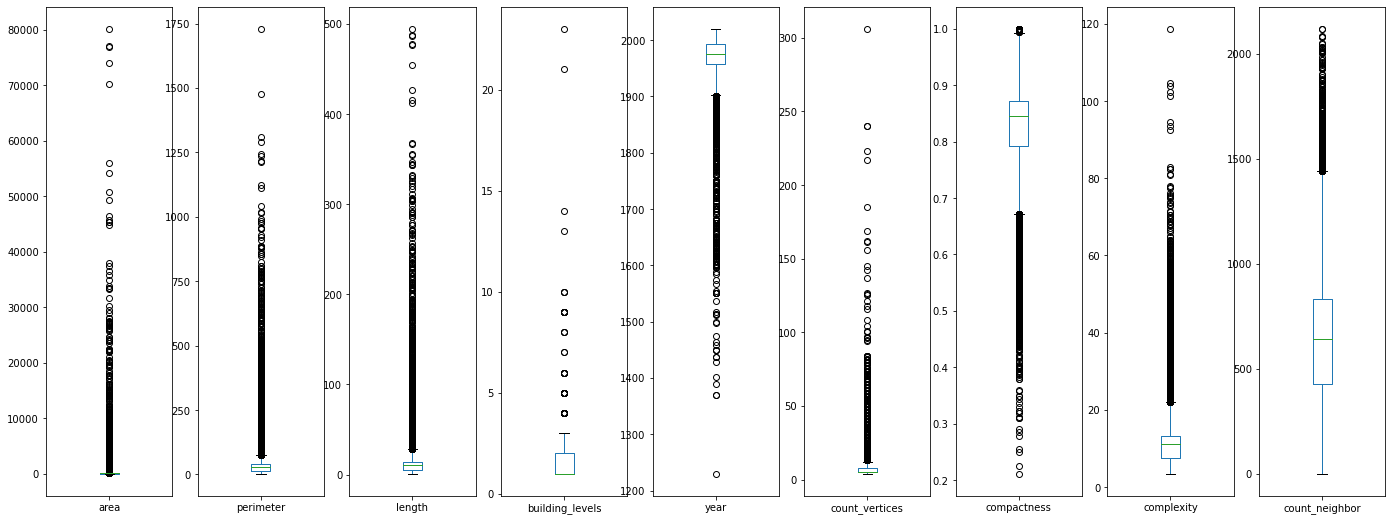

In [13]:
num_df.plot(kind='box', subplots=True, figsize=(24,9))
plt.plot()
plt.savefig('gridsearch_5prct/run0/exploratory/south_holland_basic_distribution_null.png')

In [14]:
X = ml_df.drop('bldg_height', axis=1).drop(['country', 'state_name'], axis=1).drop(['perimeter'], axis=1)
y = ml_df['bldg_height']


In [15]:

X, y

(                 area     length  building_levels city postcode    year  \
 osm_way_id                                                                
 269237142    9.397988   4.704017              NaN  NaN      NaN  1975.0   
 293025352   65.665709  12.103594              NaN  NaN      NaN  1970.0   
 282663535   48.072919  10.431649              NaN  NaN      NaN  1992.0   
 263902520   98.331731  18.686821              NaN  NaN      NaN  1978.0   
 273614892   62.358067  12.771534              NaN  NaN      NaN  2008.0   
 ...               ...        ...              ...  ...      ...     ...   
 283848908   87.866520  14.095289              NaN  NaN      NaN  2006.0   
 287836938   56.439779  12.410463              NaN  NaN      NaN  1977.0   
 290446069   38.043888   9.349915              NaN  NaN      NaN  1960.0   
 290426596    5.256300   3.354602              NaN  NaN      NaN  1951.0   
 283366416    5.899205   3.571746              NaN  NaN      NaN  1965.0   
 
          

In [16]:
mean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean', add_indicator=True)),
    ('scaler', StandardScaler())])

freq_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=1, add_indicator=True)),
    ('scaler', StandardScaler())])

zero_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=True)),
    ('scaler', StandardScaler())])

In [17]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA', add_indicator=True)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [18]:
preprocessor = ColumnTransformer(transformers=[
        ('mean_transformer', mean_transformer, ["year"]),
        ('freq_transformer', freq_transformer, ["building_levels"]),
        ('zero_transformer', zero_transformer, ["count_neighbor"]),
        ('cat_transfomer', cat_transformer, cat_cols)])

In [19]:
regressor = GradientBoostingRegressor(
    n_estimators=500, 
    learning_rate=0.1,
    subsample=0.5,
    max_depth=6,
    max_features=0.5,
    random_state=model_seed)

In [20]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])

In [22]:
param_grid = {
    'regressor__subsample': [0.4, 0.5, 0.6],
    'regressor__max_depth': [6, 7, 8],
    'regressor__max_features': [0.4, 0.5, 0.6]
}

In [23]:
cv = ShuffleSplit(n_splits=10, test_size=.2, random_state=cv_seed)
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='neg_mean_absolute_error')
grid_result = grid_search.fit(X, y)


In [24]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best: -2.862921 using {'regressor__max_depth': 6, 'regressor__max_features': 0.4, 'regressor__subsample': 0.6}


In [25]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']


In [26]:
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-2.870446 (0.012719) with: {'regressor__max_depth': 6, 'regressor__max_features': 0.4, 'regressor__subsample': 0.4}
-2.866455 (0.011709) with: {'regressor__max_depth': 6, 'regressor__max_features': 0.4, 'regressor__subsample': 0.5}
-2.862921 (0.012705) with: {'regressor__max_depth': 6, 'regressor__max_features': 0.4, 'regressor__subsample': 0.6}
-2.874914 (0.011513) with: {'regressor__max_depth': 6, 'regressor__max_features': 0.5, 'regressor__subsample': 0.4}
-2.872151 (0.013370) with: {'regressor__max_depth': 6, 'regressor__max_features': 0.5, 'regressor__subsample': 0.5}
-2.868502 (0.011751) with: {'regressor__max_depth': 6, 'regressor__max_features': 0.5, 'regressor__subsample': 0.6}
-2.882556 (0.012227) with: {'regressor__max_depth': 6, 'regressor__max_features': 0.6, 'regressor__subsample': 0.4}
-2.878529 (0.010335) with: {'regressor__max_depth': 6, 'regressor__max_features': 0.6, 'regressor__subsample': 0.5}
-2.875570 (0.012505) with: {'regressor__max_depth': 6, 'regressor__max_f

In [27]:
ml_df = full_df.sample(frac=0.1, random_state=sampling_seed)
ml_df.head()

,osm_way_id,bldg_height,area,perimeter,length,building_levels,city,country,postcode,year,count_vertices,compactness,complexity,count_neighbor,state_name
40804,264836743,2.42,5.195833,10.618467,4.123150,NaN,None,NL,None,1924.0,9,0.760976,7.033120,1055.0,South Holland
590057,267117894,2.98,19.672993,17.741781,6.283066,NaN,None,NL,None,1967.0,5,0.886223,8.424218,592.0,South Holland
180369,271318196,7.00,67.148396,39.661883,14.246583,NaN,None,NL,None,1900.0,9,0.732402,13.855252,366.0,South Holland
235581,267507750,4.53,14.079382,15.991232,5.987078,NaN,None,NL,None,1928.0,5,0.831792,8.255360,747.0,South Holland
1462995,274873848,5.37,73.554720,35.248687,12.752673,NaN,None,NL,None,2006.0,8,0.862516,12.036225,243.0,South Holland


In [28]:
ml_df.set_index('osm_way_id', inplace=True)

ml_df["city"] = ml_df["city"].astype("category")
ml_df["postcode"] = ml_df["postcode"].astype("category")
ml_df["country"] = ml_df["country"].astype("category")
ml_df["state_name"] = ml_df["state_name"].astype("category")

ml_df.dtypes

bldg_height         float64
area                float64
perimeter           float64
length              float64
building_levels     float64
city               category
country            category
postcode           category
year                float64
count_vertices        int64
compactness         float64
complexity          float64
count_neighbor      float64
state_name         category
dtype: object

In [29]:
ml_df.shape

(163867, 14)

In [30]:
ml_df.isna().sum()


bldg_height             0
area                    0
perimeter               0
length                  0
building_levels    161657
city               163763
country                 0
postcode           163767
year                   12
count_vertices          0
compactness             0
complexity              0
count_neighbor         23
state_name              0
dtype: int64

In [31]:
print('unique city:', pd.unique(ml_df['city']))
print('unique postcode:', pd.unique(ml_df['postcode']))

unique city: [NaN, Schipluiden, 's-Gravenhage, Nootdorp, Capelle aan den IJssel, ..., Zuidland, Bleiswijk, Hoornaar, Voorschoten, Lekkerkerk]
Length: 46
Categories (45, object): [Schipluiden, 's-Gravenhage, Nootdorp, Capelle aan den IJssel, ..., Bleiswijk, Hoornaar, Voorschoten, Lekkerkerk]
unique postcode: [NaN, 2636AX, 2512XT, 2631CL, 2565DD, ..., 2555MA, 2742AR, 2251XJ, 2718CX, 2941XL]
Length: 97
Categories (96, object): [2636AX, 2512XT, 2631CL, 2565DD, ..., 2742AR, 2251XJ, 2718CX, 2941XL]


In [32]:
label_col = ["bldg_height"]
# num_cols = ["area", "perimeter", "length", "building_levels", "year", "count_vertices", "compactness", "complexity", "count_neighbor"]
num_cols = ["area", "perimeter", "length", "building_levels", "year", "count_vertices", "compactness", "complexity", "count_neighbor"]
cat_cols = ["city", "postcode"]
# cat_cols = [col for col in df.columns if col not in (num_cols + label_col)]

In [33]:
cat_df = ml_df[cat_cols]
num_df = ml_df[num_cols]

In [34]:
num_df.describe()

,area,perimeter,length,building_levels,year,count_vertices,compactness,complexity,count_neighbor
count,163867.000000,163867.000000,163867.000000,2210.000000,163855.000000,163867.000000,163867.000000,163867.000000,163844.000000
mean,125.492926,34.522280,12.518419,1.509955,1970.069189,7.336956,0.820119,11.524784,626.722498
std,1069.277467,42.379305,14.821906,1.562676,36.870584,5.292078,0.070320,5.181012,308.035036
min,0.027453,0.664537,0.238380,-3.000000,1200.000000,4.000000,0.234890,1.632569,1.000000
25%,11.136349,13.900014,5.076650,1.000000,1957.000000,5.000000,0.791238,7.592439,429.000000
50%,50.121256,29.811309,10.876016,1.000000,1976.000000,5.000000,0.843896,11.149701,639.000000
75%,71.677965,38.926945,14.329673,1.000000,1993.000000,8.000000,0.871879,13.342793,833.000000
max,96144.116296,2229.810651,553.170701,25.000000,2020.000000,366.000000,0.999713,140.535339,2119.000000


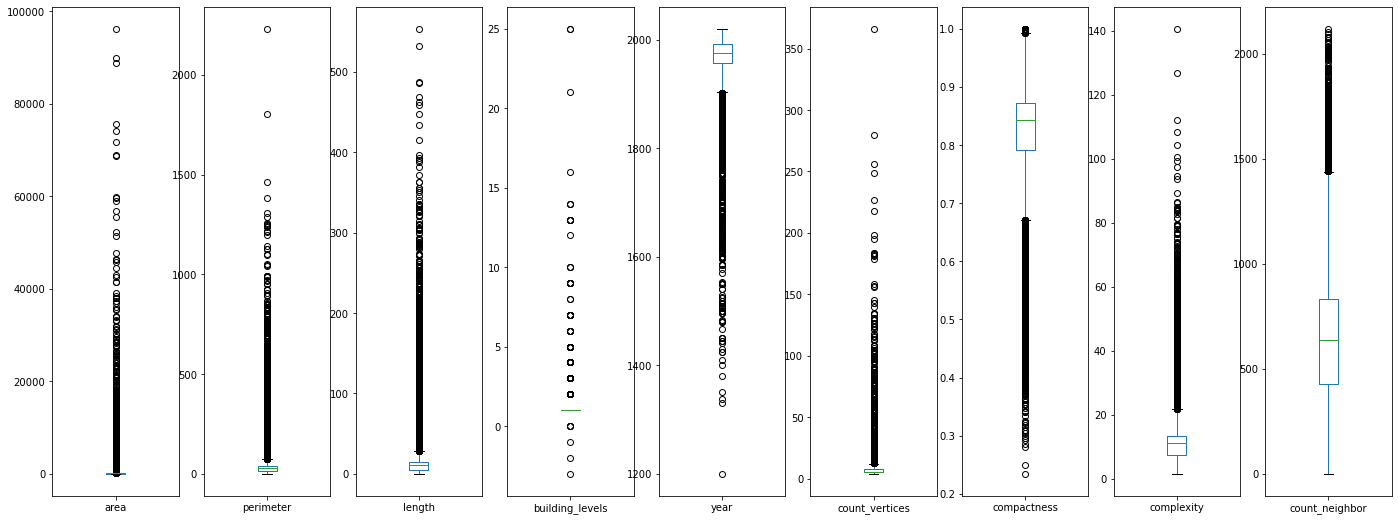

In [35]:
num_df.plot(kind='box', subplots=True, figsize=(24,9))
plt.plot()
plt.savefig('gridsearch_10prct/run0/exploratory/south_holland_basic_distribution_null.png')

In [36]:
X = ml_df.drop('bldg_height', axis=1).drop(['country', 'state_name'], axis=1).drop(['perimeter'], axis=1)
y = ml_df['bldg_height']


In [37]:

X, y

(                 area     length  building_levels city postcode    year  \
 osm_way_id                                                                
 264836743    5.195833   4.123150              NaN  NaN      NaN  1924.0   
 267117894   19.672993   6.283066              NaN  NaN      NaN  1967.0   
 271318196   67.148396  14.246583              NaN  NaN      NaN  1900.0   
 267507750   14.079382   5.987078              NaN  NaN      NaN  1928.0   
 274873848   73.554720  12.752673              NaN  NaN      NaN  2006.0   
 ...               ...        ...              ...  ...      ...     ...   
 267386182   20.710564   7.431233              NaN  NaN      NaN  1995.0   
 272299255   49.994129  10.570029              NaN  NaN      NaN  1997.0   
 272177317   56.781469  11.172970              NaN  NaN      NaN  1968.0   
 265479829   52.243959  11.281866              NaN  NaN      NaN  1995.0   
 560538169   66.637461  12.869032              NaN  NaN      NaN  2015.0   
 
          

In [38]:
mean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean', add_indicator=True)),
    ('scaler', StandardScaler())])

freq_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=1, add_indicator=True)),
    ('scaler', StandardScaler())])

zero_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=True)),
    ('scaler', StandardScaler())])

In [39]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA', add_indicator=True)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [40]:
preprocessor = ColumnTransformer(transformers=[
        ('mean_transformer', mean_transformer, ["year"]),
        ('freq_transformer', freq_transformer, ["building_levels"]),
        ('zero_transformer', zero_transformer, ["count_neighbor"]),
        ('cat_transfomer', cat_transformer, cat_cols)])

In [41]:
regressor = GradientBoostingRegressor(
    n_estimators=500, 
    learning_rate=0.1,
    subsample=0.5,
    max_depth=6,
    max_features=0.5,
    random_state=model_seed)

In [42]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])

In [43]:
param_grid = {
    'regressor__subsample': [0.4, 0.5, 0.6],
    'regressor__max_depth': [6, 7, 8],
    'regressor__max_features': [0.4, 0.5, 0.6]
}

In [44]:
cv = ShuffleSplit(n_splits=10, test_size=.2, random_state=cv_seed)
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='neg_mean_absolute_error')
grid_result = grid_search.fit(X, y)


In [45]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best: -2.831121 using {'regressor__max_depth': 6, 'regressor__max_features': 0.4, 'regressor__subsample': 0.6}


In [46]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']


In [47]:
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-2.833654 (0.010260) with: {'regressor__max_depth': 6, 'regressor__max_features': 0.4, 'regressor__subsample': 0.4}
-2.832765 (0.010612) with: {'regressor__max_depth': 6, 'regressor__max_features': 0.4, 'regressor__subsample': 0.5}
-2.831121 (0.010047) with: {'regressor__max_depth': 6, 'regressor__max_features': 0.4, 'regressor__subsample': 0.6}
-2.835811 (0.010657) with: {'regressor__max_depth': 6, 'regressor__max_features': 0.5, 'regressor__subsample': 0.4}
-2.834695 (0.010446) with: {'regressor__max_depth': 6, 'regressor__max_features': 0.5, 'regressor__subsample': 0.5}
-2.833088 (0.010223) with: {'regressor__max_depth': 6, 'regressor__max_features': 0.5, 'regressor__subsample': 0.6}
-2.840092 (0.011772) with: {'regressor__max_depth': 6, 'regressor__max_features': 0.6, 'regressor__subsample': 0.4}
-2.837863 (0.010875) with: {'regressor__max_depth': 6, 'regressor__max_features': 0.6, 'regressor__subsample': 0.5}
-2.835569 (0.011215) with: {'regressor__max_depth': 6, 'regressor__max_f